In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningBatchLinearVAE
from catvae.sim import multinomial_batch_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import torch
import argparse
import seaborn as sns
import pandas as pd

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

from pytorch_lightning.profiler import AdvancedProfiler

In [2]:
np.random.seed(0)
k = 20
C = 3
sims = multinomial_batch_bioms(k=k, D=100, N=2000, M=1e6, C=C)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

md = pd.DataFrame({'batch_category': sims['batch_idx']}, index=samp_ids)
md.index.name = 'sampleid'
md.to_csv('metadata.txt', sep='\t')
batch_priors = pd.Series(sims['alpha'], index=obs_ids)
batch_priors.to_csv('batch_priors.txt', sep='\t')

sims['tree'].write('basis.nwk')

'basis.nwk'

Run batch effects removal VAE

In [3]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'test.biom',
    '--val-biom', 'valid.biom',
    '--sample-metadata', 'metadata.txt',
    '--batch-category', 'batch_category',
    '--batch-prior', 'batch_priors.txt',
    '--basis', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '10000',
    '--batch-size', '200',
    '--encoder-depth', '1',
    '--num-workers', '3',
    '--scheduler', 'none',
    '--learning-rate', '1e-3',
    '--n-latent', f'{k}',
    '--n-hidden', '64',
    '--gpus', '1'
]

parser = argparse.ArgumentParser(add_help=False)
parser = LightningBatchLinearVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningBatchLinearVAE(args)
# Give the model the right answer to see how it behaves
#model.initialize_batch(torch.Tensor(sims['B']))
#model.model.decoder.weight.data = torch.Tensor(sims['W'])
#model.model.beta.weight.data = torch.Tensor(sims['B'])
model.set_eigs(sims['eigvectors'], sims['eigs'])
profiler = AdvancedProfiler()
print(model)

LightningBatchLinearVAE(
  (model): LinearBatchVAE(
    (encoder): Encoder(
      (encoder): Linear(in_features=99, out_features=20, bias=False)
    )
    (decoder): ParametrizedLinear(
      in_features=20, out_features=99, bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): Grassmannian(n=99, k=20, triv=matrix_exp)
        )
      )
    )
    (beta): Embedding(3, 99)
  )
)


In [4]:
trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=1,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type           | Params
-----------------------------------------
0 | model | LinearBatchVAE | 4 K   


Exception ignored in: <function _releaseLock at 0x7f0dbd947ee0>
Traceback (most recent call last):
  File "/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 29762, 29763) exited unexpectedly

(0.8724591902812433, 0.0)


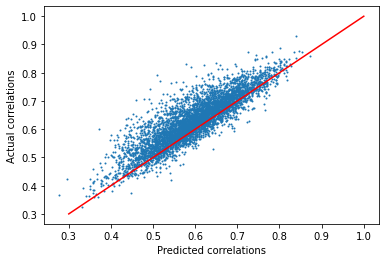

In [5]:
#W = model.get_embedding(exclude_batch=True, eps=1e-3).detach().cpu().numpy()
W = model.model.decoder.weight.detach().cpu().numpy()
d_estW = pdist(W)
simW = sims['W'] / np.sqrt(sims['eigs'])
dW = pdist(simW)

plt.scatter(dW, d_estW, s=1)
plt.plot(np.linspace(0.3, 1), np.linspace(0.3, 1), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

(0.41841163158532335, 0.0)


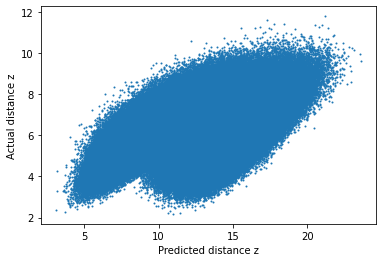

In [7]:
x = torch.Tensor(sims['Y']).float().cuda()
b = torch.Tensor(sims['batch_idx']).long().cuda()
z = model.model.encode(x, b)

dsimz = pdist(sims['z'])
dz = pdist(z.detach().cpu().numpy())
plt.scatter(dz, dsimz, s=1)
plt.xlabel('Predicted distance z')
plt.ylabel('Actual distance z')
print(pearsonr(dz, dsimz))

In [ ]:
i = np.argsort(md['batch_category'].values[:parts * 8])
sns.heatmap(z[i].detach().cpu().numpy())

In [ ]:
B = model.model.beta.weight.detach().cpu().numpy().T
d_estB = pdist(B)
simB = sims['B'].T
dB = pdist(simB)

plt.scatter(dB, d_estB, s=1)
#plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted batch correlations')
plt.ylabel('Actual batch correlations')

print(pearsonr(dB, d_estB))

In [ ]:
W.shape, sims['W'].shape

In [ ]:
model.model.decoder.weight[:, C:].shape

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs